## Car Price Prediction Regression Model

### Project from Machine Learning Bookcamp, Alexey Grigorev
### Copyright 2021, Manning Publications

Written in Python version 3.10.7 <br>
Jupyter Notebook built on Windows 11 local server using VS Code Jupyter Extension v2022.8.1002431955

This project covers the following objectives:
*Creating a regression model from scratch (that is, direct application of linear algebra, not using built-in regression functions)
*Exploratory data analysis
*Setting up and implementing a validation framework
*Performing basic feature engineering
*Controlling model through regularization
*Using the model to predict car prices 

The main section of the project primarily follows code from book. Occasional comments and explanations are my own. All code and commentary in "Challenge Problems" section (code block 41 to end) is entirely my own.

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

#allows jupyter to display plots correctly
%matplotlib inline

data source: https://www.kaggle.com/datasets/CooperUnion/cardataset <br>
downloaded 21 Sep 2022 (no license information at time of download)


In [2]:
df = pd.read_csv('data.csv')

In [3]:
#check number of observations in table
len(df)

11914

In [4]:
#examine structure
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [5]:
#lowercase all column names and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

#select all columns with string values
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

#lowercases and replaces spaces with underscores for all string values
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [6]:
#examine structure after initial cleaning
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


<AxesSubplot: xlabel='msrp', ylabel='Count'>

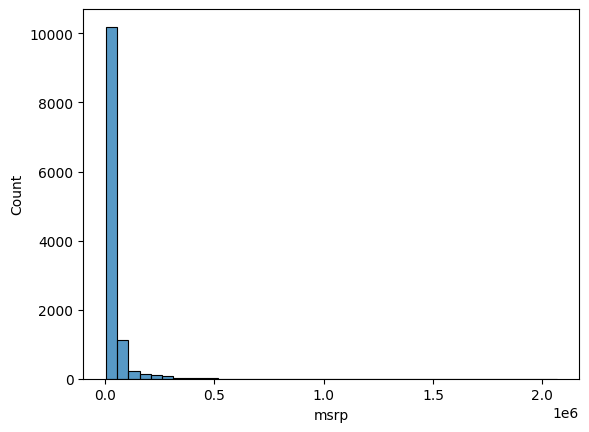

In [7]:
#visualize distribution of prices
sns.histplot(df.msrp, bins = 40)

<AxesSubplot: xlabel='msrp', ylabel='Count'>

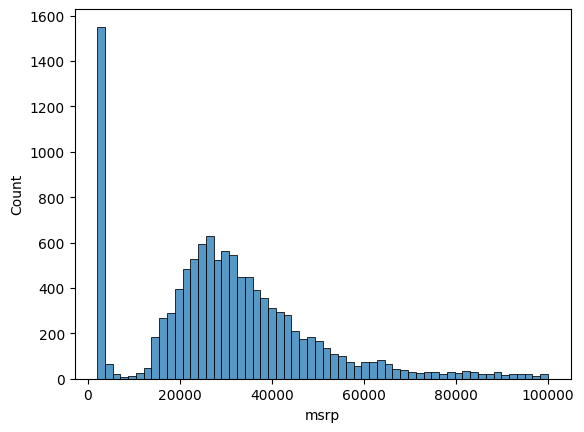

In [8]:
#let's cut out the crazy expensive cars to see most of the data
sns.histplot(df.msrp[df.msrp < 100000])

<AxesSubplot: xlabel='msrp', ylabel='Count'>

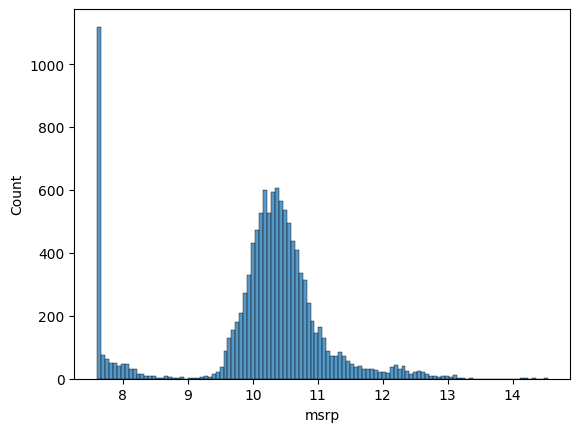

In [9]:
#take the log transform of prices to account for high values
log_price = np.log1p(df.msrp)

#plot log of prices
sns.histplot(log_price)

In [10]:
#check for null values
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

In [11]:
### split df into training (60%), validation (20%), and test (20%) sets

#get number of rows in df
n = len(df)

#calculates number of rows in each partition
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - n_val - n_test

#set seed
np.random.seed(2)

#create array from 0 to n-1 and shuffle
idx = np.arange(n)
np.random.shuffle(idx)

#shuffle original dataframe per output of previous line
df_shuffled = df.iloc[idx]

#create separate datasets
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val:].copy()

In [12]:
#create log transform of msrp for each partition
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

In [13]:
#delete price column
#ensures outputs aren't accidentally included in feature set
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

In [14]:
#linear regression algorithm
def train_linear_regression(X, y):
    #add dummy column
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    #set up normal equation to calculate weights
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    #return bias term and rest of weights separately
    return w[0], w[1:]

In [15]:
#select features for model training
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 
        'city_mpg', 'popularity']
df_num = df_train[base]

#set all NAs equal to 0
#setting to 0 rather than imputing values because:
# 1. NAs are small proportion of data (<1% in selected columns)
# 2. Will result in NAs being ignored in results.
# Because of the small proportion, this 
# shouldn't overly bias resulting model.
df_num = df_num.fillna(0)

#create numpy array of values
X_train = df_num.values

#create regression model from selected features
w_0, w = train_linear_regression(X_train, y_train)

In [16]:
#get regression outputs using training data
y_pred = w_0 + X_train.dot(w)

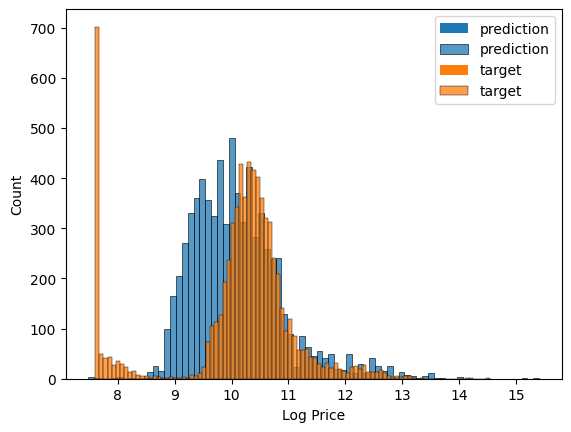

In [17]:
#plot predictions vs. actual distribution
sns.histplot(y_pred, label = 'prediction')
sns.histplot(y_train, label = 'target')
plt.xlabel('Log Price')
plt.legend() #not totally sure why this doubles the legend

#this model does not appear to match our target very well
#in general, the model produces lower prices compared to the real value

In [18]:
#...but how much worse can't easily be quantified from the graph

#function to find root mean squared error (RMSE)
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

rmse_base = rmse(y_train, y_pred)
rmse_base
#root mean squared error is e^(0.76), since output is log transformed

0.7554192603920132

In [19]:
#feature engineering

#create derived age variable
df_train.year.max() #newest vehicle from 2017 - use this as baseline

2017

In [20]:
#subtract model year from 2017 to find age
df_train['age'] = 2017 - df_train.year

In [21]:
#function to clean up all datasets
#calculates and appends age, fills NAs with zeroes

def prepare_X(df):
    df = df.copy() #copy prevents side effects
    features = base.copy()
    
    df['age'] = 2017 - df.year
    features.append('age')
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [22]:
#check to see if adding age to model improves fit

#first clean up training and validation dataframes
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

#train model and predict validation output
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_val.dot(w)

#calculate rmse
print('validation:', rmse(y_val, y_pred))
#rmse is lower than before - now only e^(0.51)

validation: 0.5172055461058299


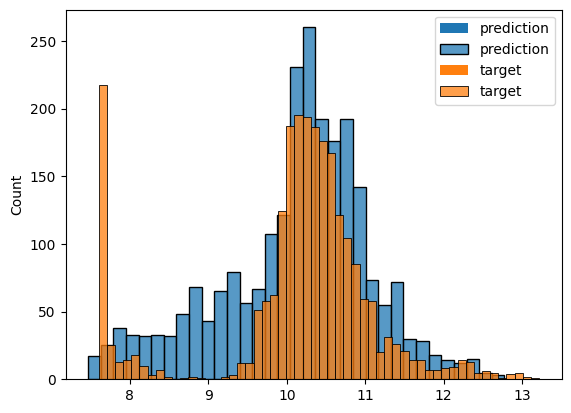

In [23]:
#plot this output - clearly better match than previous
sns.histplot(y_pred, label = 'prediction')
sns.histplot(y_val, label = 'target')
plt.legend()

In [24]:
#adding another feature - number of doors

#first, we need to encode number of doors as a categorical variable
#we also want to try to factor in make
#add to prepare_X function

def prepare_X(df):
    df = df.copy() #copy prevents side effects
    features = base.copy()
    
    #calculate age relative to creation of dataset (2017)
    df['age'] = 2017 - df.year
    features.append('age')
    
    #create categorical variables (T-F) based on number of doors
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        #encode True-False as 1 and 0
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)
        
    #create categorical variables (T-F) based on common makes
    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature) 
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [25]:
#run model again
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

In [26]:
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

#slightly better than the last, but only by factor of ~e^0.01

validation: 0.50760388495567


In [27]:
#add more categorical features

def prepare_X(df):
    #the smart way to do this would have been
    #to write a function to do this by category
    #we'll fix it in post
    ###(maybe this is slightly more computationally efficient than
    ###repeatedly finding unique values though?)
    
    df = df.copy() #copy prevents side effects
    features = base.copy()
    
    #calculate age relative to creation of dataset (2017)
    df['age'] = 2017 - df.year
    features.append('age')
    
    #create categorical variables (T-F) based on number of doors
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        #encode True-False as 1 and 0
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)
        
    #create categorical variables (T-F) based on common makes
    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)
    
    #fuel type
    for v in ['regular_unleaded', 'premium_unleaded_(required)',
              'premium_unleaded_(recommended)',
              'flex-fuel_(unleaded/e85)']:
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)
    
    #transmission type
    for v in ['automatic', 'manual', 'automated_manual']:
        feature = 'is_transmission_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)
        
    #drivetrain type
    for v in ['front_wheel_drive', 'rear_wheel_drive', 
             'all_wheel_drive', 'four_wheel_drive']:
        feature = 'is_driven_wheels_%s' % v
        df[feature] = (df['driven_wheels'] == v).astype(int)
        features.append(feature)
    
    #market category type
    for v in ['crossover', 'flex_fuel', 'luxury', 'luxury,performance',
             'hatchback']:
        feature = 'is_mc_%s' % v
        df[feature] = (df['market_category'] == v).astype(int)
        features.append(feature)
        
    #size
    for v in ['compact', 'midsize', 'large']:
        feature = 'is_size_%s' % v
        df[feature] = (df['vehicle_size'] == v).astype(int)
        features.append(feature)
    
    #style
    for v in ['sedan', '4dr_suv', 'coupe', 'convertible', 
             '4dr_hatchback']:
        feature = 'is_style_%s' % v
        df[feature] = (df['vehicle_style'] == v).astype(int)
        features.append(feature)
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [28]:
#run model again
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

#this is MASSIVELY worse than before - multiple orders of magnitude!

validation: 49.873533583264866


In [29]:
#why is this worse? let's check w_0 and w
print(w_0, w)
#the bias term - w_0 - has an extreme negative value!

-2765770327625654.0 [-2.96152341e-02  1.48385504e+00 -2.02208746e-01  5.87693934e+00
 -8.73768713e-03  1.00915575e+00  1.22843884e+03  1.22405055e+03
  1.21055658e+03 -3.94291505e+00  2.95829625e+01 -3.11315579e+01
 -9.59444240e+00  1.13775195e+01 -6.93387792e+01 -7.50488444e+01
 -8.67311064e+01 -6.28864984e+01  7.05316803e+02  7.11500463e+02
  7.90258140e+02  2.76577033e+15  2.76577033e+15  2.76577033e+15
  2.76577033e+15  1.06406250e+01  5.29161740e+00 -1.59142884e+01
 -5.52287650e+00  2.12653527e+01  1.04462289e+01  3.25743754e+01
  4.86575180e+01 -7.67460186e-02  4.14645821e-02  1.86187511e-01
  3.55798979e-01 -2.14066472e-01]


In [30]:
#This is probably due to numerical instability -
#most likely due to adding nearly identical columns with the
#addition of lots of categorical variables. For instance, the 
#'flex-fuel' fuel type and 'flex_fuel' market categories are probably
#almost identical.

#In order to fix this, we need to regularize the matrix (aka
#ridge regression).

In [31]:
#add regularization term to training function

def train_linear_regression_reg(X, y, r=0.0):
    #add dummy column for bias term
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    #calculate XTX and add reguluarization term
    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    
    #get weights
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [32]:
#let's try different values of r
for r in [0, 0.001, 0.01, 0.1, 1, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r = r)
    print('%5s, %.2f, %.2f, %.2f' % (r, w_0, w[13], w[21]))

#even a tiny regularization term seems to produce reasonable coefficients

    0, -2765770327625654.00, 11.38, 2765770327623687.00
0.001, 7.20, -0.10, 1.81
 0.01, 7.18, -0.10, 1.81
  0.1, 7.05, -0.10, 1.78
    1, 6.22, -0.10, 1.56
   10, 4.39, -0.09, 1.08


In [33]:
#run a model with r = 0.001
X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r = 0.001)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))
#and now we get our best rmse yet - just e^(0.46)...

validation: 0.46022676259116185


In [34]:
#...which comes out to an absolute factor of about 1.58
np.exp(0.46)

1.5840739849944818

In [35]:
#trying other values of r
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

for r in range(-6,2):
    w_0, w = train_linear_regression_reg(X_train, y_train, r = 10**r)
    y_pred = w_0 + X_val.dot(w)
    print(10**r, round(rmse(y_val, y_pred),5))

1e-06 0.46023
1e-05 0.46023
0.0001 0.46023
0.001 0.46023
0.01 0.46024
0.1 0.46037
1 0.46183
10 0.47572


In [36]:
#rmse values for r below 0.1 are nearly identical

#taking r = 0.1 to build the final model
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)
X_test = prepare_X(df_test)

w_0, w = train_linear_regression_reg(X_train, y_train, r = 0.01)
y_pred = w_0 + X_val.dot(w)
print('validation:', round(rmse(y_val, y_pred), 5))

y_pred = w_0 + X_test.dot(w)
print('test:', round(rmse(y_test, y_pred), 5))
#these are pretty close, so it looks like we can use the model

validation: 0.46024
test: 0.45718


In [37]:
#try out model on new data

#first, build the new car
ad = {
    'city_mpg': 18,
    'driven_wheels': 'all_wheel_drive',
    'engine_cylinders': 6.0,
    'engine_fuel_type': 'regular_unleaded',
    'engine_hp': 268.0,
    'highway_mpg': 25,
    'make': 'toyota',
    'market_category': 'crossover,performance',
    'model': 'venza',
    'number_of_doors': 4.0,
    'popularity': 2031,
    'transmission_type': 'automatic',
    'vehicle_size': 'midsize',
    'vehicle_style': 'wagon',
    'year': 2013
}

In [38]:
#transform into dataframe
df_test = pd.DataFrame([ad])

X_test = prepare_X(df_test)

y_pred = w_0 + X_test.dot(w)
y_pred[0]
#note that produces the log of the final output

10.250445193514558

In [39]:
#undo the log transform
suggested_price = np.expm1(y_pred)
round(suggested_price[0], 2)

28294.14

In [40]:
#The actual price of this car is 31120
actual_price = 31120
diff = round(suggested_price[0] - actual_price, 2)
diff
#the model was about $2800 too low - which is pretty good

-2825.86

## Challenge Problems

### Exercise 1 - write a helper function for binary encoding to call within prepare_X

In [41]:
#this is what I should have done when writing the very long prepare_X function

def encode_cat(v, col):
    #v is a single column of a dataframe (but any one-dimensional iterable should work)
    #col is a string used to name output columns
    #output is pd.DataFrame of binary values and list of new feature names (strings)
    
    df = pd.DataFrame()
    features = []
    
    for val in v.unique():
        feature =  col + ('_%s' % val)
        df[feature] = (v == val).astype(int)
        features.append(feature)
    
    return df, features

In [42]:
#test above function

def prepare_X_var2(df):
    
    df = df.copy() #copy prevents side effects
    features = base.copy()
    
    #calculate age relative to creation of dataset (2017)
    df['age'] = 2017 - df.year
    features.append('age')
    
    for col in ['number_of_doors', 'make', 'engine_fuel_type', 'transmission_type',
               'driven_wheels', 'market_category', 'vehicle_size',
               'vehicle_style']:
        col_df, col_feat = encode_cat(df[col], col)
        df = pd.concat([df, col_df], axis = 1)
        features.extend(col_feat)
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X, features

In [43]:
X_train2, f = prepare_X_var2(df_train)

In [44]:
len(X_train2) == len(X_train)

True

In [45]:
X_train2.shape

(7150, 166)

### Exercise 2 - Try additional feature engineering.

In the original regression model, we used no more than the top five values for any categorical variable. The `encode_cat() ` function in exercise 1 already extends this to factor all levels of each category, for a total of 169 dimensions in the original DataFrame. However, we will need to substantially modify the code in order to get outputs of the right dimensions for our training/validation/test sets and any simulated outside data.

Because of the extent of the redesign, I chose to start from scratch and reload fresh data from the CSV.

In [46]:
#for this exercise, we need to start with the whole dataset, run through prepare_X_var2, THEN split
#if we don't do it this way, we might end up with different dimensions in the training, test,
#and validation matrices

#start with fresh read of data
df = pd.read_csv('data.csv')

#lowercase all column names and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

#select all columns with string values
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

#lowercases and replaces spaces with underscores for all string values
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

#get number of rows in df
n = len(df)

#calculates number of rows in each partition
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - n_val - n_test

#set seed
np.random.seed(2) #same seed as above, so dataset should end up split the same way

#create array from 0 to n-1 and shuffle
idx = np.arange(n)
np.random.shuffle(idx)

#shuffle original dataframe per output of previous line
df_shuffled = df.iloc[idx]

#create log transform of msrp for each partition
y_train = np.log1p(df_shuffled.iloc[:n_train].copy().msrp.values)
y_val = np.log1p(df_shuffled.iloc[n_train:n_train + n_val].copy().msrp.values)
y_test = np.log1p(df_shuffled.iloc[n_train + n_val:].copy().msrp.values)

del df_shuffled['msrp']

X_prepared, features_prepared = prepare_X_var2(df_shuffled)

In [47]:
#create separate datasets
X_train = X_prepared[:n_train,].copy()
X_val = X_prepared[n_train:n_train + n_val,].copy()
X_test = X_prepared[n_train + n_val:,].copy()

In [48]:
for r in range(-6,2):
    w_0, w = train_linear_regression_reg(X_train, y_train, r = 10**r)
    y_pred = w_0 + X_val.dot(w)
    print(10**r, round(rmse(y_val, y_pred),5))

1e-06 0.40774
1e-05 0.40774
0.0001 0.40774
0.001 0.40773
0.01 0.40766
0.1 0.40722
1 0.40729
10 0.4259


In [49]:
#it looks like r = 0.1 is slightly better this time
w_0, w = train_linear_regression_reg(X_train, y_train, r = 0.1)
y_pred = w_0 + X_val.dot(w)
print('validation:', round(rmse(y_val, y_pred), 5))

y_pred = w_0 + X_test.dot(w)
print('test:', round(rmse(y_test, y_pred), 5))

validation: 0.40722
test: 0.39689


This time, we get even better results - RMSE on both the validation and test sets is about e^0.4 = 1.49, compared to 1.58 without the additional features. That being said, the additional improvement is fairly small. Significant improvement to model accuracy would probably require either additional data, perhaps about the buyers or dealerships, or more advanced models (regression trees might be an option).

In order to get this to work with new data, however, we need to ensure that any new data is transformed properly into the new column format. Because of the way the new encoding function works, it isn't as simple as running it directly through the transform we did earlier. I modified the prepare_X_var2 function to also return the feature list - we will use it here to create a new DataFrame with the right columns.

In [50]:
#use the same car as before
ad = {
    'city_mpg': 18,
    'driven_wheels': 'all_wheel_drive',
    'engine_cylinders': 6.0,
    'engine_fuel_type': 'regular_unleaded',
    'engine_hp': 268.0,
    'highway_mpg': 25,
    'make': 'toyota',
    'market_category': 'crossover,performance',
    'model': 'venza',
    'number_of_doors': 4.0,
    'popularity': 2031,
    'transmission_type': 'automatic',
    'vehicle_size': 'midsize',
    'vehicle_style': 'wagon',
    'year': 2013
}

In [51]:
#this function will prepare new data to match formatted DataFrame

def prepare_data(newcar, f):
    #newcar is a dictionary of car attributes - all keys must be strings
    #f is the ordered list of features in the regression model
    #output is 1d np.array 
    
    init_array = np.zeros(len(f))
    car = pd.Series(data = init_array, index = f)
    
    for k, v in newcar.items():
        
        #add numeric values with matching keys directly to car Series
        if k in car.index and (type(v) == int or type(v) == float):
            car[k] = v
        
        #raise error if key matches but non-numeric value passed
        elif k in car.index and type(v) != int and type(v) != float:
            raise ValueError('Value for ' + k + ' should be numeric.')
        
        #year variable gets transformed to age
        elif k == 'year':
            car['age'] == 2017 - v
        
        #process categorical variables - 'model' attribute is not included in regression model
        else:
            idx_name = k + ('_%s' % v)
            if idx_name in car.index: #if category exists, assign value of 1 to that index
                car[idx_name] = 1
            #if category doesn't exist, skip it
    
    return car.to_numpy()

Let's also add in a simple function to give us the predicted price for a single car.

In [52]:
def predict_price(car, w_0, w):
    #car is a numpy array-like object (np.array, pd.Series, or pd.DataFrame should all work)
    #w_0 is numeric bias term from regression model
    #w is weights vector from regression model
    #output is single numeric value (if car is 1 dimensional) or array (if car is multi-dimensional)
    
    return np.exp(w_0 + car.dot(w))

In [53]:
ad_prepared = prepare_data(ad, features_prepared)

pred_price = round(predict_price(ad_prepared, w_0, w), 2)
print('Predicted price: %s' % pred_price)

Predicted price: 41848.5


In [54]:
#The actual price of this car is 31120
actual_price = 31120
diff = round(pred_price - actual_price, 2)
diff

10728.5

For this particular car, our new model actually performed worse than the original with fewer features. The suggested price here ended up being over 10000 dollars higher than the actual price (compared to about 2800 below for the original model). This is not a representative sample, however, and both our test and validation sets had less average error than the mean model.